In [3]:
import subprocess

# Define the command to create the Conda environment
command = "conda create -n fpp python=3.9"

# Run the command using subprocess
subprocess.run(command, shell=True)

CompletedProcess(args='conda create -n fpp python=3.9', returncode=127)

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn import metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import pickle

In [5]:
train_data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/flight price prediction/Flight Dataset/Data_Train.xlsx')
train_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [6]:
train_data['Destination'].value_counts()

Cochin       4537
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

In [7]:
def newd(x):
    if x=='New Delhi':
        return 'Delhi'
    else:
        return x

train_data['Destination'] = train_data['Destination'].apply(newd)

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [9]:
train_data['Journey_day'] = pd.to_datetime(train_data['Date_of_Journey'],format='%d/%m/%Y').dt.day
train_data['Journey_month'] = pd.to_datetime(train_data['Date_of_Journey'],format='%d/%m/%Y').dt.month

train_data.drop('Date_of_Journey',inplace=True,axis=1)

train_data.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month
0,IndiGo,Banglore,Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,9,6
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,12,5
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,1,3


In [10]:
train_data['Dep_hour'] = pd.to_datetime(train_data['Dep_Time']).dt.hour
train_data['Dep_min'] = pd.to_datetime(train_data['Dep_Time']).dt.minute
train_data.drop('Dep_Time',axis=1,inplace=True)

train_data['Arrival_hour'] = pd.to_datetime(train_data['Arrival_Time']).dt.hour
train_data['Arrival_min'] = pd.to_datetime(train_data['Arrival_Time']).dt.minute
train_data.drop('Arrival_Time',axis=1,inplace=True)

train_data.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min
0,IndiGo,Banglore,Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,12,5,18,5,23,30
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,1,3,16,50,21,35


In [11]:
train_data['Duration'].value_counts()

2h 50m     550
1h 30m     386
2h 45m     337
2h 55m     337
2h 35m     329
          ... 
31h 30m      1
30h 25m      1
42h 5m       1
4h 10m       1
47h 40m      1
Name: Duration, Length: 368, dtype: int64

In [12]:
duration = list(train_data['Duration'])

for i in range(len(duration)):
    if len(duration[i].split()) != 2:
        if 'h' in duration[i]:
            duration[i] = duration[i] + ' 0m'
        else:
            duration[i] = '0h ' + duration[i]

duration_hour = []
duration_min = []

for i in duration:
    h,m = i.split()
    duration_hour.append(int(h[:-1]))
    duration_min.append(int(m[:-1]))

train_data['Duration_hours'] = duration_hour
train_data['Duration_mins'] = duration_min

train_data.drop('Duration',axis=1,inplace=True)
train_data.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,Delhi,BLR → DEL,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,Delhi,BLR → NAG → DEL,1 stop,No info,13302,1,3,16,50,21,35,4,45


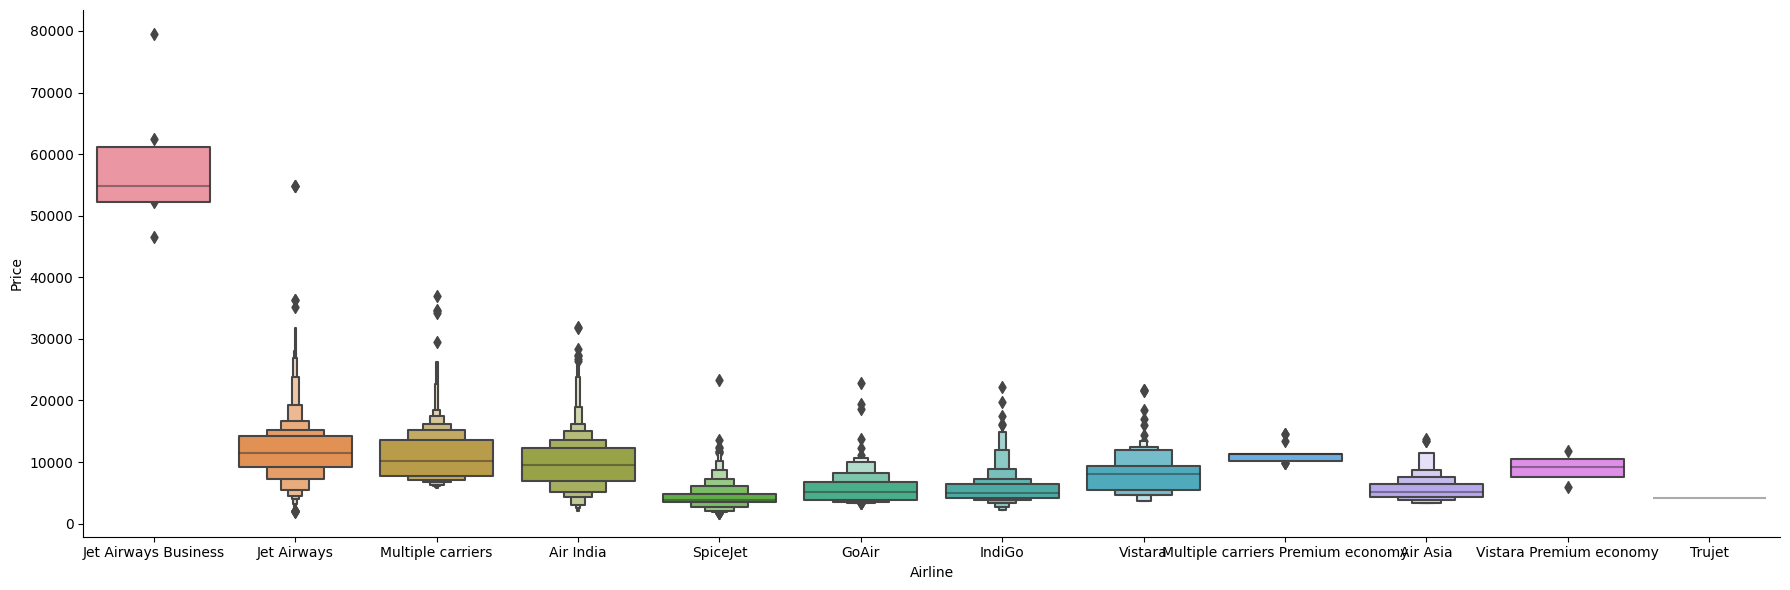

In [13]:
sns.catplot(x='Airline',y='Price',data=train_data.sort_values('Price',ascending=False),kind='boxen',aspect=3,height=6)

In [14]:
airline = train_data[['Airline']]
airline = pd.get_dummies(airline,drop_first=True)

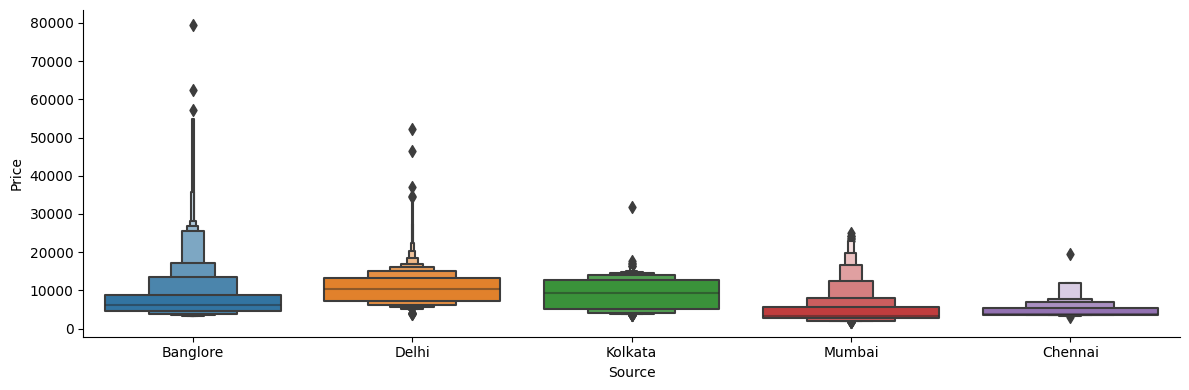

In [15]:
# If we are going from Banglore the prices are slightly higher as compared to other cities
sns.catplot(x='Source',y='Price',data=train_data.sort_values('Price',ascending=False),kind='boxen',aspect=3,height=4)

In [16]:
source = train_data[['Source']]
source = pd.get_dummies(source,drop_first=True)
source.head()

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


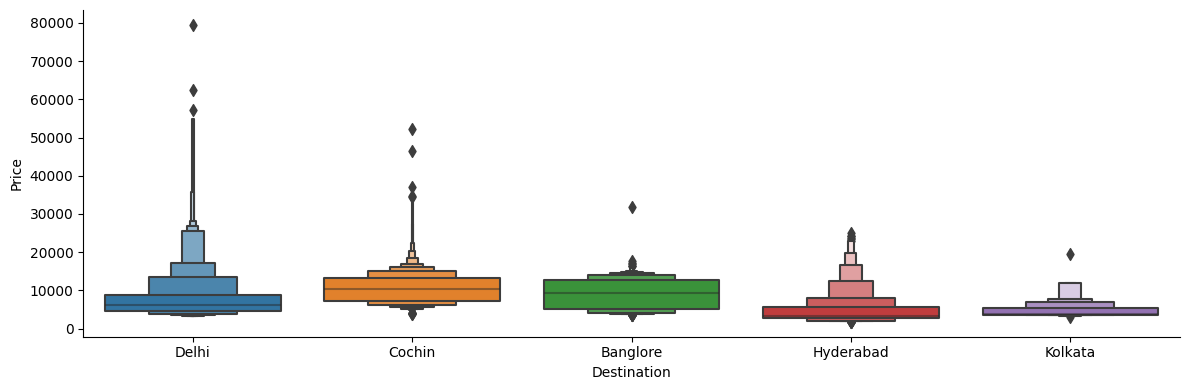

In [17]:
# If we are going to New Delhi the prices are slightly higher as compared to other cities
sns.catplot(x='Destination',y='Price',data=train_data.sort_values('Price',ascending=False),kind='boxen',aspect=3,height=4)

In [18]:
destination = train_data[['Destination']]
destination = pd.get_dummies(destination,drop_first=True)
destination.head()

,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0,1,0,0
1,0,0,0,0
2,1,0,0,0
3,0,0,0,0
4,0,1,0,0


In [19]:
train_data.drop(['Route','Additional_Info'],inplace=True,axis=1)

In [20]:
train_data['Total_Stops'].value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

In [21]:
# acc to the data, price is directly prop to the no. of stops
train_data['Total_Stops'].replace({'non-stop':0,'1 stop':1,'2 stops':2,'3 stops':3,'4 stops':4},inplace=True)
train_data.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,Delhi,0.0,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2.0,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2.0,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1.0,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,Delhi,1.0,13302,1,3,16,50,21,35,4,45


In [22]:
print(airline.shape)
print(source.shape)
print(destination.shape)
print(train_data.shape)

(10683, 11)
(10683, 4)
(10683, 4)
(10683, 13)


In [23]:
data_train = pd.concat([train_data,airline,source,destination],axis=1)
data_train.drop(['Airline','Source','Destination'],axis=1,inplace=True)
data_train.head()

,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,...,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0.0,3897,24,3,22,20,1,10,2,50,...,0,0,0,0,0,0,0,1,0,0
1,2.0,7662,1,5,5,50,13,15,7,25,...,0,0,0,0,1,0,0,0,0,0
2,2.0,13882,9,6,9,25,4,25,19,0,...,0,0,0,1,0,0,1,0,0,0
3,1.0,6218,12,5,18,5,23,30,5,25,...,0,0,0,0,1,0,0,0,0,0
4,1.0,13302,1,3,16,50,21,35,4,45,...,0,0,0,0,0,0,0,1,0,0


<ipython-input-24-8164b48cb263>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_data.corr(),cmap='viridis',annot=True)


<Axes: >

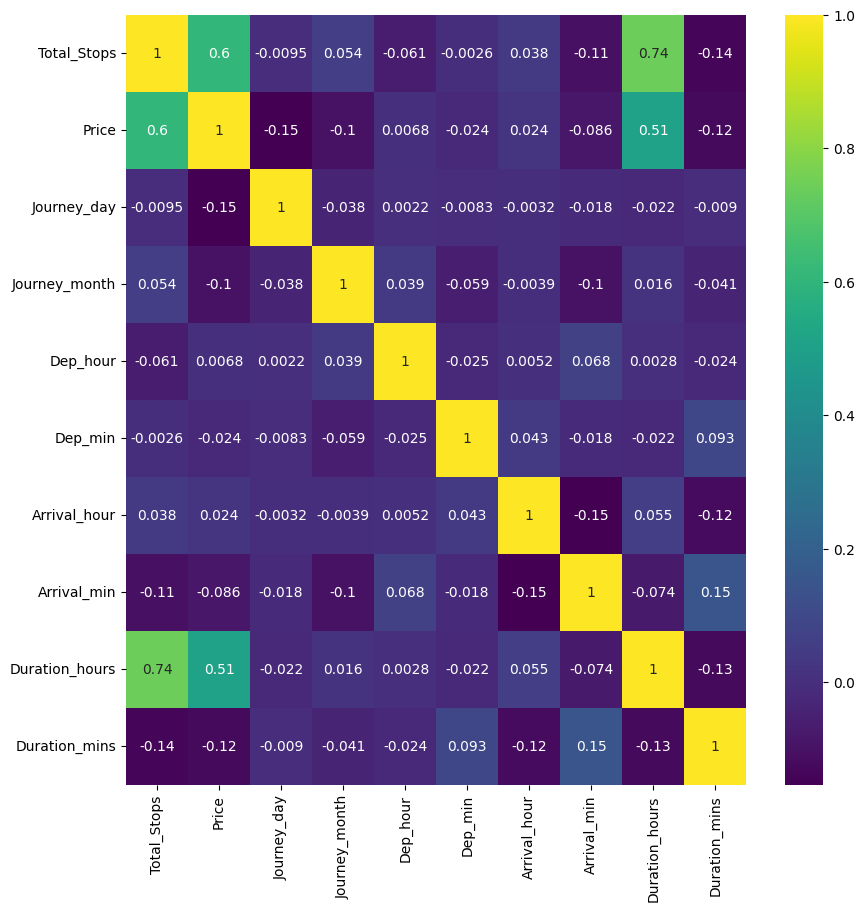

In [24]:
plt.figure(figsize=(10,10))
sns.heatmap(train_data.corr(),cmap='viridis',annot=True)

In [25]:
# Check for NaN values
nan_columns = data_train.columns[data_train.isna().any()]
nan_count = data_train[nan_columns].isna().sum()

# # Impute NaN values with the mean of the respective column
# train_data.fillna(train_data.mean(), inplace=True)

# Alternatively you can drop rows with NaN values
data_train.dropna(inplace=True)

In [26]:
print(len(train_data))

10683


In [27]:
X = data_train.drop('Price',axis=1)
X.head()

,Total_Stops,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Airline_Air India,...,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0.0,24,3,22,20,1,10,2,50,0,...,0,0,0,0,0,0,0,1,0,0
1,2.0,1,5,5,50,13,15,7,25,1,...,0,0,0,0,1,0,0,0,0,0
2,2.0,9,6,9,25,4,25,19,0,0,...,0,0,0,1,0,0,1,0,0,0
3,1.0,12,5,18,5,23,30,5,25,0,...,0,0,0,0,1,0,0,0,0,0
4,1.0,1,3,16,50,21,35,4,45,0,...,0,0,0,0,0,0,0,1,0,0


In [28]:
y = data_train['Price']
y.head()

0     3897
1     7662
2    13882
3     6218
4    13302
Name: Price, dtype: int64

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [30]:
from sklearn.ensemble import ExtraTreesRegressor

# Assuming you have X_train and y_train with missing values

# Combine X_train and y_train into a single DataFrame for easier manipulation
import pandas as pd
data = pd.concat([X_train, y_train], axis=1)

# Drop rows with missing values
data_clean = data.dropna()

# Separate the cleaned data back into X_train_clean and y_train_clean
X_train_clean = data_clean.drop(columns=['Price'])
y_train_clean = data_clean['Price']

# Create and fit the ExtraTreesRegressor on the cleaned data
regressor = ExtraTreesRegressor()
regressor.fit(X_train_clean, y_train_clean)


ExtraTreesRegressor()

In [31]:
reg = ExtraTreesRegressor()
reg.fit(X,y)

print(reg.feature_importances_)

[2.61614329e-01 1.42562740e-01 5.78250998e-02 2.32329501e-02
 2.11272265e-02 2.89467317e-02 1.90469397e-02 1.07000365e-01
 1.80933586e-02 8.68766433e-03 1.93677091e-03 1.64613088e-02
 1.37656995e-01 6.72870476e-02 1.89884530e-02 8.55267156e-04
 5.75712662e-03 1.14369308e-04 4.74345904e-03 7.07254939e-05
 7.11081574e-04 1.19658699e-02 4.47878469e-03 8.16569852e-03
 6.05273533e-03 1.81753051e-02 7.71137135e-03 7.30226121e-04]


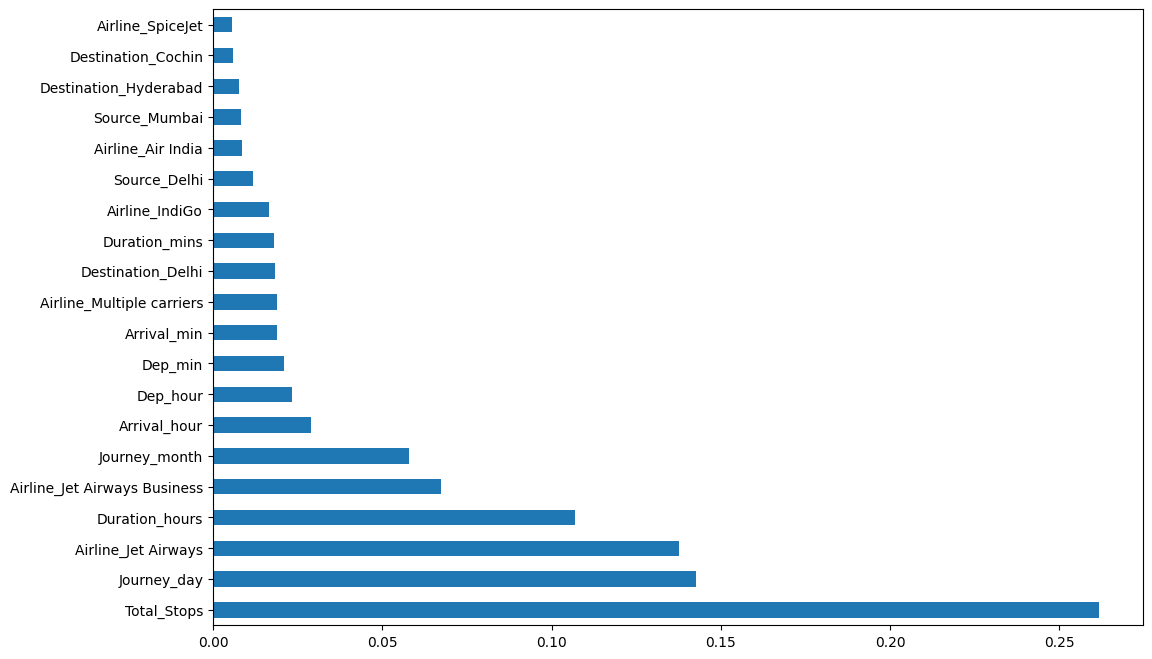

In [32]:
plt.figure(figsize = (12,8))
feat_importances = pd.Series(reg.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [33]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


# Random search of parameters, using 5 fold cross validation, search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = RandomForestRegressor(), param_distributions = random_grid,
                               scoring='neg_mean_squared_error', n_iter = 10, cv = 5,
                               verbose=1, random_state=42, n_jobs = 1)
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [34]:
rf_random.best_params_

{'n_estimators': 700,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20}

In [35]:
# Flight Price Prediction
prediction = rf_random.predict(X_test)

<ipython-input-36-b322b1d393bd>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test-prediction)


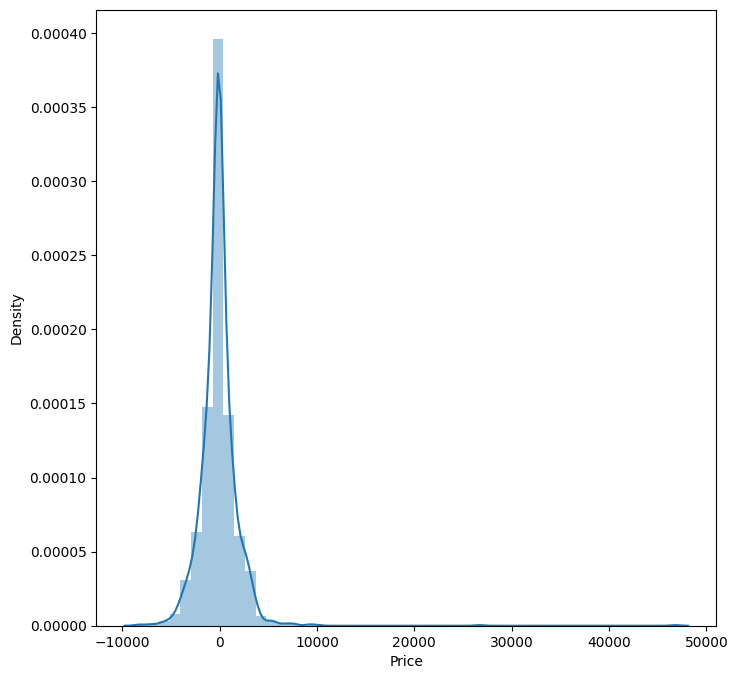

In [36]:
plt.figure(figsize = (8,8))
sns.distplot(y_test-prediction)
plt.show()

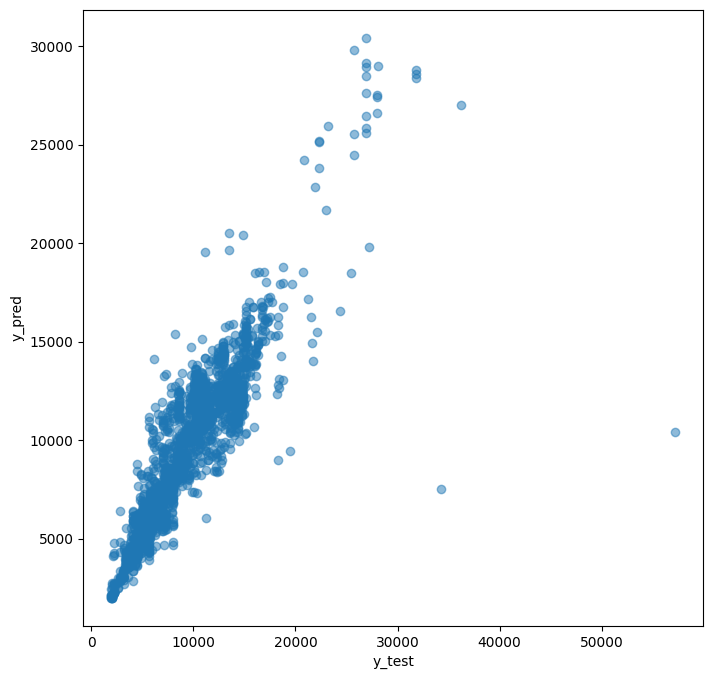

In [37]:
plt.figure(figsize = (8,8))
plt.scatter(y_test, prediction, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [38]:
print('r2 score: ', metrics.r2_score(y_test,prediction))

r2 score:  0.8082949773516255


In [39]:
file = open('flight_rf.pkl', 'wb')
pickle.dump(rf_random, file)

In [40]:
pip install flask_cors

In [43]:
from flask import Flask,request,render_template
from flask_cors import cross_origin
import pickle
import pandas as pd

model = pickle.load(open('flight_rf.pkl','rb'))

app = Flask(__name__)

@app.route('/')
@cross_origin()
def home():
	return render_template('home.html')

@app.route('/predict',methods=['GET','POST'])
@cross_origin()
def predict():
    if request.method=='POST':
        dep_time = request.form['Dep_Time']

        Journey_day = pd.to_datetime(dep_time,format="%Y-%m-%dT%H:%M").day
        Journey_month = pd.to_datetime(dep_time,format="%Y-%m-%dT%H:%M").month

        Departure_hour = pd.to_datetime(dep_time,format="%Y-%m-%dT%H:%M").hour
        Departure_min = pd.to_datetime(dep_time,format="%Y-%m-%dT%H:%M").minute

        arrival_time = request.form['Arrival_Time']
        Arrival_hour =  pd.to_datetime(arrival_time,format="%Y-%m-%dT%H:%M").hour
        Arrival_min =  pd.to_datetime(arrival_time,format="%Y-%m-%dT%H:%M").minute

        Total_stops = int(request.form['stops'])

        dur_hour = abs(Arrival_hour-Departure_hour)
        dur_min = abs(Arrival_min-Departure_min)

        airline=request.form['airline']
        if(airline=='Jet Airways'):
            Jet_Airways = 1
            IndiGo = 0
            Air_India = 0
            Multiple_carriers = 0
            SpiceJet = 0
            Vistara = 0
            GoAir = 0
            Multiple_carriers_Premium_economy = 0
            Jet_Airways_Business = 0
            Vistara_Premium_economy = 0
            Trujet = 0

        elif (airline=='IndiGo'):
            Jet_Airways = 0
            IndiGo = 1
            Air_India = 0
            Multiple_carriers = 0
            SpiceJet = 0
            Vistara = 0
            GoAir = 0
            Multiple_carriers_Premium_economy = 0
            Jet_Airways_Business = 0
            Vistara_Premium_economy = 0
            Trujet = 0

        elif (airline=='Air India'):
            Jet_Airways = 0
            IndiGo = 0
            Air_India = 1
            Multiple_carriers = 0
            SpiceJet = 0
            Vistara = 0
            GoAir = 0
            Multiple_carriers_Premium_economy = 0
            Jet_Airways_Business = 0
            Vistara_Premium_economy = 0
            Trujet = 0

        elif (airline=='Multiple carriers'):
            Jet_Airways = 0
            IndiGo = 0
            Air_India = 0
            Multiple_carriers = 1
            SpiceJet = 0
            Vistara = 0
            GoAir = 0
            Multiple_carriers_Premium_economy = 0
            Jet_Airways_Business = 0
            Vistara_Premium_economy = 0
            Trujet = 0

        elif (airline=='SpiceJet'):
            Jet_Airways = 0
            IndiGo = 0
            Air_India = 0
            Multiple_carriers = 0
            SpiceJet = 1
            Vistara = 0
            GoAir = 0
            Multiple_carriers_Premium_economy = 0
            Jet_Airways_Business = 0
            Vistara_Premium_economy = 0
            Trujet = 0

        elif (airline=='Vistara'):
            Jet_Airways = 0
            IndiGo = 0
            Air_India = 0
            Multiple_carriers = 0
            SpiceJet = 0
            Vistara = 1
            GoAir = 0
            Multiple_carriers_Premium_economy = 0
            Jet_Airways_Business = 0
            Vistara_Premium_economy = 0
            Trujet = 0

        elif (airline=='GoAir'):
            Jet_Airways = 0
            IndiGo = 0
            Air_India = 0
            Multiple_carriers = 0
            SpiceJet = 0
            Vistara = 0
            GoAir = 1
            Multiple_carriers_Premium_economy = 0
            Jet_Airways_Business = 0
            Vistara_Premium_economy = 0
            Trujet = 0

        elif (airline=='Multiple carriers Premium economy'):
            Jet_Airways = 0
            IndiGo = 0
            Air_India = 0
            Multiple_carriers = 0
            SpiceJet = 0
            Vistara = 0
            GoAir = 0
            Multiple_carriers_Premium_economy = 1
            Jet_Airways_Business = 0
            Vistara_Premium_economy = 0
            Trujet = 0

        elif (airline=='Jet Airways Business'):
            Jet_Airways = 0
            IndiGo = 0
            Air_India = 0
            Multiple_carriers = 0
            SpiceJet = 0
            Vistara = 0
            GoAir = 0
            Multiple_carriers_Premium_economy = 0
            Jet_Airways_Business = 1
            Vistara_Premium_economy = 0
            Trujet = 0

        elif (airline=='Vistara Premium economy'):
            Jet_Airways = 0
            IndiGo = 0
            Air_India = 0
            Multiple_carriers = 0
            SpiceJet = 0
            Vistara = 0
            GoAir = 0
            Multiple_carriers_Premium_economy = 0
            Jet_Airways_Business = 0
            Vistara_Premium_economy = 1
            Trujet = 0

        elif (airline=='Trujet'):
            Jet_Airways = 0
            IndiGo = 0
            Air_India = 0
            Multiple_carriers = 0
            SpiceJet = 0
            Vistara = 0
            GoAir = 0
            Multiple_carriers_Premium_economy = 0
            Jet_Airways_Business = 0
            Vistara_Premium_economy = 0
            Trujet = 1

        else:
            Jet_Airways = 0
            IndiGo = 0
            Air_India = 0
            Multiple_carriers = 0
            SpiceJet = 0
            Vistara = 0
            GoAir = 0
            Multiple_carriers_Premium_economy = 0
            Jet_Airways_Business = 0
            Vistara_Premium_economy = 0
            Trujet = 0

        Source = request.form["Source"]
        if (Source == 'Delhi'):
            s_Delhi = 1
            s_Kolkata = 0
            s_Mumbai = 0
            s_Chennai = 0

        elif (Source == 'Kolkata'):
            s_Delhi = 0
            s_Kolkata = 1
            s_Mumbai = 0
            s_Chennai = 0

        elif (Source == 'Mumbai'):
            s_Delhi = 0
            s_Kolkata = 0
            s_Mumbai = 1
            s_Chennai = 0

        elif (Source == 'Chennai'):
            s_Delhi = 0
            s_Kolkata = 0
            s_Mumbai = 0
            s_Chennai = 1

        else:
            s_Delhi = 0
            s_Kolkata = 0
            s_Mumbai = 0
            s_Chennai = 0


        Destination = request.form["Destination"]
        if (Destination == 'Cochin'):
            d_Cochin = 1
            d_Delhi = 0
            d_Hyderabad = 0
            d_Kolkata = 0

        elif (Destination == 'Delhi'):
            d_Cochin = 0
            d_Delhi = 1
            d_Hyderabad = 0
            d_Kolkata = 0

        elif (Destination == 'Hyderabad'):
            d_Cochin = 0
            d_Delhi = 0
            d_Hyderabad = 1
            d_Kolkata = 0

        elif (Destination == 'Kolkata'):
            d_Cochin = 0
            d_Delhi = 0
            d_Hyderabad = 0
            d_Kolkata = 1

        else:#Banglore
            d_Cochin = 0
            d_Delhi = 0
            d_Hyderabad = 0
            d_Kolkata = 0

        output = model.predict([[Total_stops,
            Journey_day,
            Journey_month,
            Departure_hour,
            Departure_min,
            Arrival_hour,
            Arrival_min,
            dur_hour,
            dur_min,
            Air_India,
            GoAir,
            IndiGo,
            Jet_Airways,
            Jet_Airways_Business,
            Multiple_carriers,
            Multiple_carriers_Premium_economy,
            SpiceJet,
            Trujet,
            Vistara,
            Vistara_Premium_economy,
            s_Chennai,
            s_Delhi,
            s_Kolkata,
            s_Mumbai,
            d_Cochin,
            d_Delhi,
            d_Hyderabad,
            d_Kolkata]])

        output = round(output[0],2)
        return render_template('home.html',predictions='You will have to Pay approx Rs. {}'.format(output))


if __name__ == '__main__':
	app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
